In [1]:
try:
    # import google.colab # type: ignore
    # from google.colab import output
    %pip install -q transformer-lens matplotlib numpy seaborn torch hf_transfer tqdm scikit-learn
except:
    from IPython import get_ipython  # type: ignore

    ipython = get_ipython()
    assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import json
import random
import transformers
import numpy as np
import tqdm
import matplotlib.pyplot as plt


from grid_functions import *
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

import os
# Avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# My imports
from dataset import GridTextDataset
from dataset import get_dataloader
from linear_model import LinearProbe, train_linear_probe_all_layers
from analysis import *
from plotting import plot_metric_vs_layer, plot_layer_usage_heatmap


In [3]:
transformers.__version__

'4.57.3'

## Loading Model

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# if the model is not downloaded, this might be needed

#access_token = "hf_TOKEN"

#tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)
#model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)

In [5]:
# Load the model using transformer-lens
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


## Load Data

In [6]:
# test loading
with open("data/grid_simple_dataset.json", "r") as f:
    loaded_dataset = json.load(f)

Vizualize one point of the dataset on the grid

In [7]:
torch_dataset = GridTextDataset(loaded_dataset)
torch_dataset.__getitem__(0)  # Test getting the first item

train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=8)

Training dataset len: 480
Validation dataset len: 60
Test dataset len: 60


Text form:
You are solving a grid navigation task.

The grid is 5x5.
Coordinates are (x, y).
x increases to the RIGHT.
y increases DOWN.
The top-left cell is (0, 0).

Agent position: (0, 2)
Goal position: (3, 4)

Reason step by step about the spatial relationship.
Then write:

ACTION:
Visualizing grid:


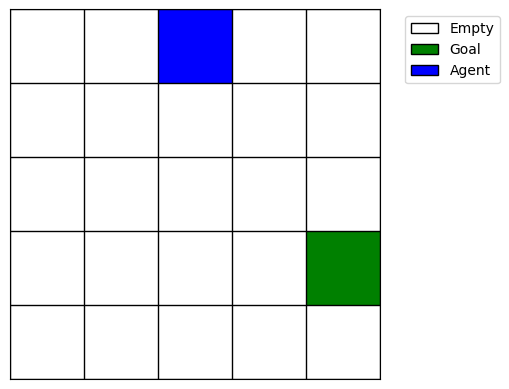

In [8]:
for batch in train_loader:
    text = batch["text"][0]
    type_text = batch["text_type"][0]
    goal_grid = batch["goal_grid"][0]
    agent_grid = batch["agent_grid"][0]
    print("Text form:")
    print(text)
    print("Visualizing grid:")
    visualize_binary_grid(goal_grid, agent_grid, 5, 5)
    break

In [9]:
# Test generation on dataset prompts

outputs = model.generate(
    text,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.1,
    top_p=0.9
)

print(outputs)

  0%|          | 0/100 [00:00<?, ?it/s]

You are solving a grid navigation task.

The grid is 5x5.
Coordinates are (x, y).
x increases to the RIGHT.
y increases DOWN.
The top-left cell is (0, 0).

Agent position: (0, 2)
Goal position: (3, 4)

Reason step by step about the spatial relationship.
Then write:

ACTION: move to (1, 2)
REASON: I am at (0, 2). I want to go to (3, 4). I can only move one cell at a time. I can move RIGHT or DOWN. I move RIGHT because that is the direction that will get me closer to the goal. I move RIGHT because I am at (0, 2) and I want to go to (3, 4). I move RIGHT because I am at (0,


## Tests model: all layers

In [10]:
class LinearProbe(nn.Module):
    def __init__(self, activation_dim, num_classes=25):
        super().__init__()
        self.probe = nn.Linear(activation_dim, num_classes)

    def forward(self, activation):
        y = self.probe(activation)
        return y


In [11]:
# 131072 is all 32 layers
linear_model = LinearProbe(activation_dim=131072, num_classes=25)

In [12]:
do_train=False

if do_train:
    torch.save(linear_model.state_dict(), "./model_weights.pt")
else:
    linear_model.load_state_dict(torch.load("./model_weights.pt", weights_only=True))
    linear_model.to("cuda")



if do_train:
    history = train_linear_probe_all_layers(
        linear_model,
        model,
        train_loader,
        device='cuda',
        num_epochs=250,
        use_tqdm=True
    )

In [13]:
if do_train:
    plt.plot(history['loss'])
    plt.xlabel("Iterations")
    plt.ylabel("CE Loss")

##### Vizualizing Reconstruction

Text form:
You are solving a grid navigation task.

The grid is 5x5.
Coordinates are (x, y).
x increases to the RIGHT.
y increases DOWN.
The top-left cell is (0, 0).

Agent position: (0, 4)
Goal position: (4, 3)

Reason step by step about the spatial relationship.
Then write:

ACTION:

Visualizing original grid:


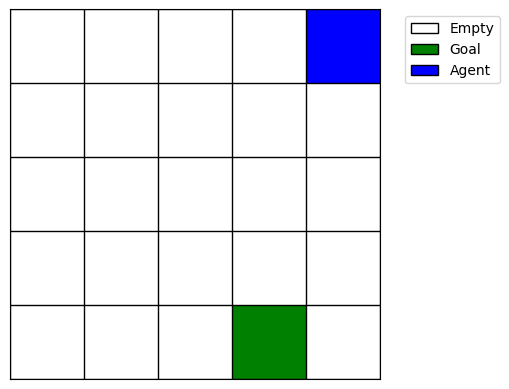


Visualizing reconstructed grid:


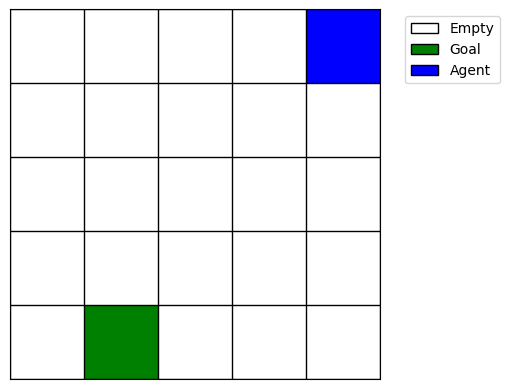

In [14]:
n_layers = model.cfg.n_layers

# index for vizualization test
idx=0
for batch in train_loader:
    text = batch["text"][idx]
    goal_grid = batch["goal_grid"][idx]
    agent_grid = batch["agent_grid"][idx]
    print("Text form:")
    print(text)
    print("\nVisualizing original grid:")
    visualize_binary_grid(goal_grid, agent_grid, 5, 5)
    break

with torch.no_grad():
    _, cache = model.run_with_cache(text)

    # Collect activations from all layers
    all_acts = [
        cache["resid_pre", layer][:, -1]
        for layer in range(n_layers)
    ]  # list of [batch, hidden]

    
    # [batch, layers, hidden]
    all_acts = torch.stack(all_acts, dim=1)

    # [batch, layers * hidden]
    # # Then authors collectd hidden states from all layers of the last token in the template.
    all_acts = all_acts.reshape(all_acts.shape[0], -1)

logits = linear_model(all_acts).detach().cpu()
probs = torch.softmax(logits, dim=-1)

pred_classes = torch.argmax(probs, dim=-1)
reconstructed_goal_grid = nn.functional.one_hot(
    pred_classes, num_classes=25
).float()

print("\nVisualizing reconstructed grid:")
visualize_binary_grid(reconstructed_goal_grid, agent_grid, 5, 5)

In [15]:
torch_dataset = GridTextDataset(loaded_dataset)
torch_dataset.__getitem__(0)  # Test getting the first item

# Changed batch size to 24, to test on all data in one go
train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=24) 

Training dataset len: 480
Validation dataset len: 60
Test dataset len: 60


In [16]:
acc = reconstruction_accuracy(
    model,
    linear_model,
    train_loader,
    "cuda"
)

print(f"Reconstruction accuracy: {acc:.4f}")

Reconstruction accuracy: 0.7896


tensor([0.0396, 0.0396, 0.0396, 0.0396, 0.0396, 0.0729, 0.0708, 0.0396, 0.0458,
        0.0792, 0.0833, 0.0750, 0.0458, 0.0458, 0.0458, 0.2729, 0.1042, 0.1729,
        0.4229, 0.3667, 0.2833, 0.3542, 0.2833, 0.3729, 0.2458, 0.2958, 0.2104,
        0.3146, 0.2125, 0.5146, 0.3396, 0.1979])
tensor(29)


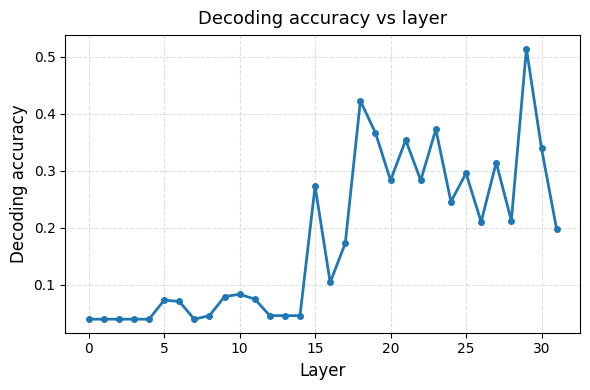

In [17]:
accs = accuracy_vs_layer(
    model=model,
    linear_model=linear_model,
    test_loader=train_loader,
    device="cuda",
)

print(accs)
print(torch.argmax(accs))

plot_metric_vs_layer(accs, "Decoding accuracy")


tensor([3.2192, 3.2181, 3.2217, 3.2204, 3.2091, 3.2004, 3.1937, 3.2246, 3.1484,
        3.1142, 3.2019, 3.1166, 3.2413, 3.2507, 3.0397, 2.3981, 2.5490, 2.5373,
        2.2009, 2.2283, 2.3013, 2.4864, 2.6317, 2.4463, 2.4389, 2.4040, 2.4042,
        2.2583, 2.2999, 1.9877, 2.1724, 3.0896])
tensor(29)


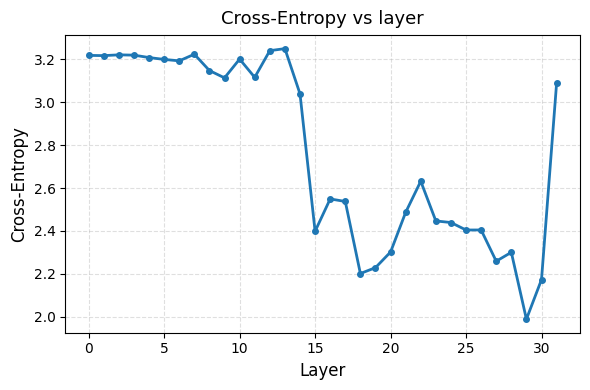

In [18]:
ce = cross_entropy_vs_layer(
    model=model,
    linear_model=linear_model,
    test_loader=train_loader,
    device="cuda",
)

print(ce)
print(torch.argmin(ce))

plot_metric_vs_layer(ce, "Cross-Entropy")


[ 6.960001    6.960001    6.960001    6.960001    7.0000014   4.629327
  5.1905494   6.960001    5.6382613   4.645489    4.5538697  -0.32913452
 -1.6104358  -1.2701992  -1.3721601   6.302495    3.273819    5.3655086
  8.073927    7.9249525   6.3690143   6.941261    7.088765    7.448603
  6.1128387   6.3439937   5.2851725   6.839663    5.197744    8.40541
  6.248973    4.3488755 ]
29


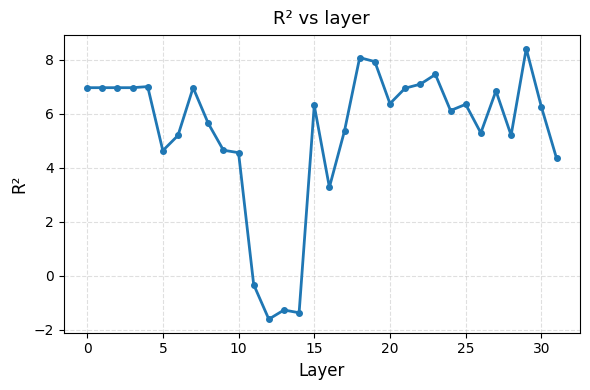

In [19]:

r2 = r2_vs_layer(
    model=model,
    linear_model=linear_model,
    test_loader=train_loader,
    device="cuda",
)

print(r2)
print(np.argmax(r2))

plot_metric_vs_layer(r2, "R²")


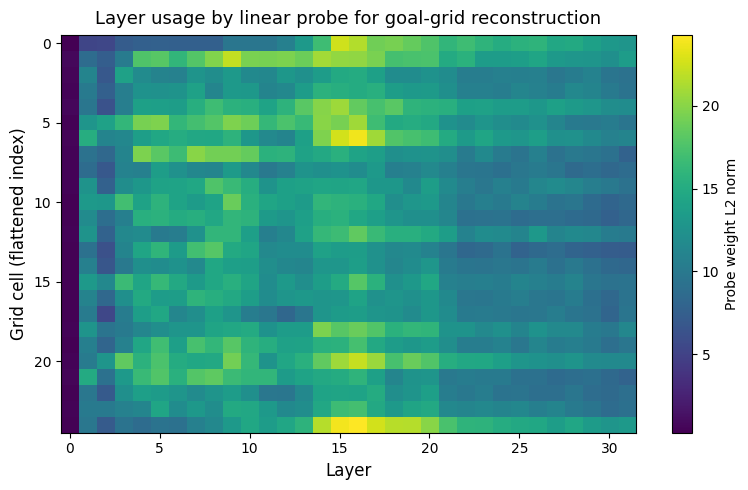

In [20]:
contrib = compute_layer_cell_contributions(linear_model, model)
plot_layer_usage_heatmap(contrib)


In [21]:
# Specificity analysis
max_indices, max_values, specificity = analyze_individual_neurons(model,
    linear_model,
    "cuda",
)

specificity_mean = np.mean(specificity, axis = 1)
specificity_flat = specificity_mean.reshape((32, 5 * 5))
specificity_flat_mean = np.mean(specificity_flat, axis=-1)
np.argmax(specificity_flat_mean)

18

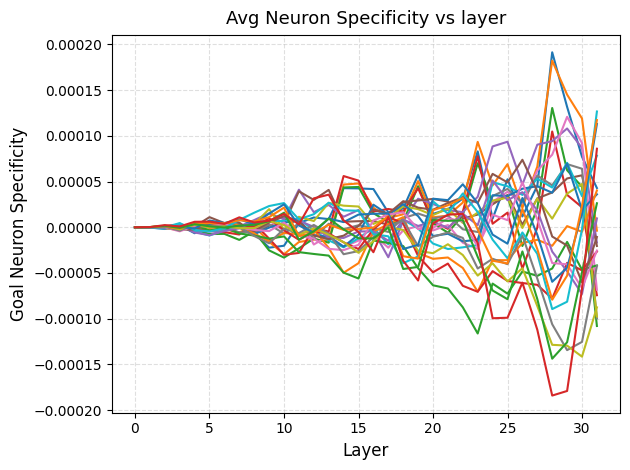

In [22]:
plt.plot(specificity_flat[:, 1:])
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Goal Neuron Specificity", fontsize=12)

plt.title(
    "Avg Neuron Specificity vs layer",
    fontsize=13,
    pad=8,
)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(
    True,
    which="both",
    linestyle="--",
    linewidth=0.8,
    alpha=0.4,
)

plt.tight_layout()
plt.show()

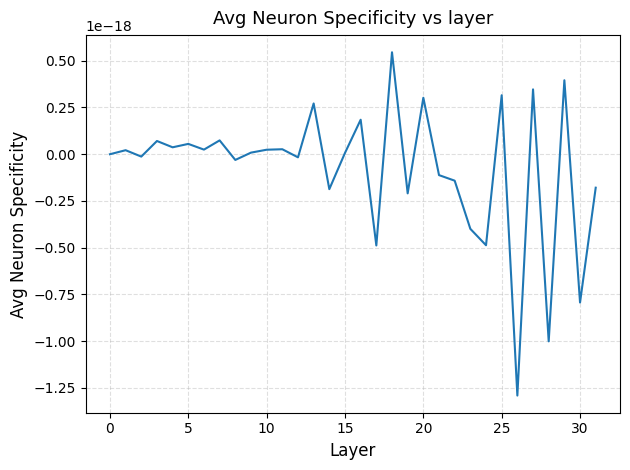

In [23]:
plt.plot(specificity_flat_mean)
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Avg Neuron Specificity", fontsize=12)

plt.title(
    "Avg Neuron Specificity vs layer",
    fontsize=13,
    pad=8,
)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(
    True,
    which="both",
    linestyle="--",
    linewidth=0.8,
    alpha=0.4,
)

plt.tight_layout()
plt.show()

## Other Dataset test

In [24]:
# test loading
with open("data/grid_simple_dataset.json", "r") as f:
    loaded_dataset = json.load(f)
    
torch_dataset = GridTextDataset(loaded_dataset)
torch_dataset.__getitem__(0)  # Test getting the first item

train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=8)

Training dataset len: 480
Validation dataset len: 60
Test dataset len: 60


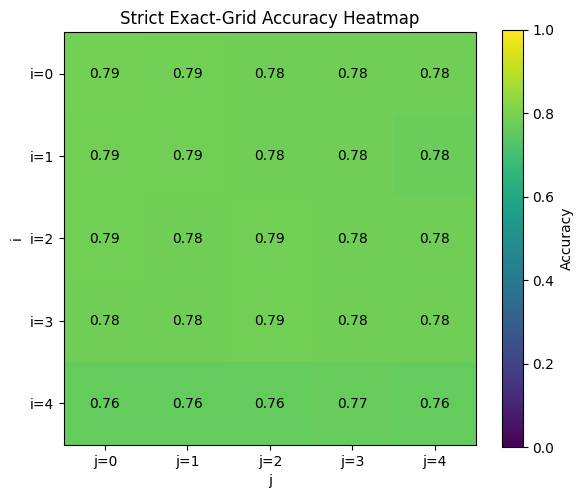

In [25]:
import numpy as np
import matplotlib.pyplot as plt

grid_size = 5
acc_grid = np.zeros((grid_size, grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        new_pos = f'({i}, {j})'
        acc = reconstruction_accuracy_with_agent_replace(
            model,
            linear_model,
            train_loader,
            new_pos,
            "cuda"
        )
        acc_grid[i, j] = acc

plt.figure(figsize=(6, 5))
plt.imshow(acc_grid, interpolation="nearest")
plt.colorbar(label="Accuracy")

plt.xticks(range(grid_size), [f"j={j}" for j in range(grid_size)])
plt.yticks(range(grid_size), [f"i={i}" for i in range(grid_size)])

plt.title("Strict Exact-Grid Accuracy Heatmap")
plt.xlabel("j")
plt.ylabel("i")
plt.clim(0,1)

for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f"{acc_grid[i, j]:.2f}",
                 ha="center", va="center")

plt.tight_layout()
plt.show()
